In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import os
import re
root_path = 'log/'

legend_font = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 12,
    }
font = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 15,
    }

colorlist = ['darkorange', 'cyan', 'lightsteelblue', 'plum', 'darkseagreen', 'gold', 'bisque', 'lightgreen', 'gray']
color_rgb_list = [(74/255, 135/255, 161/255), (222/255, 144/255, 123/255), (230/255, 197/255, 180/255), (88/255, 141/255, 106/255), (147/255, 196/255, 212/255), (237/255, 204/255, 134/255), (156/255, 131/255, 131/255), (116/255, 126/255, 73/255), (61/255, 71/255, 59/255), (36/255, 74/255, 96/255)]

def extract_number(feature, data, split_str):
    result_list = []
    for line in data:
        #print(line)
        seg = re.split(split_str, line)
        if set(feature).issubset(set(seg)):
            for item in seg:
                if item.lstrip('-').replace('.', '').replace(',', '').isdigit():
                    item = item.replace(',', '')
                    try:
                        result_list.append(int(item))  
                    except ValueError:
                        result_list.append(float(item))  
                        
    return result_list
                
def process_log(root_path, log_path, steps_feature = ['components'], \
                steps_split = ' |\n', val_split = ' |\n|\)|\(|%', val_features = ['set:', 'Accuracy:', 'Test']):
    with open(root_path + log_path, 'r') as f:
        data = f.readlines()
        steps_list = extract_number(feature = steps_feature, data = data, split_str = steps_split)
        val_list = extract_number(feature = val_features, data = data, split_str = val_split) 
    
    
    if abs(len(steps_list) -  len(val_list)) == 1:
        min_len = min(len(steps_list), len(val_list))
        return steps_list[:min_len], val_list[:min_len]
    else:
        return steps_list, val_list

def process_smooth(steps_list, val_list, smooth_len):
    steps = [0] * len(range(0, len(steps_list)-smooth_len+1, smooth_len))
    vals = [0] * len(steps)
    for i in range(0, len(steps_list)-smooth_len+1, smooth_len):
        steps[i // smooth_len]  = steps_list[i+np.argmin(val_list[i:i+smooth_len])]
        vals[i // smooth_len] = np.min(val_list[i:i+smooth_len])
    return steps, vals

In [2]:
def smooth(r_list,plot_list_len,smooth_len):
    plot_list = []
    for i in range(plot_list_len):
        plot_list.append(np.mean(r_list[i*smooth_len:(i+1)*smooth_len]))
    return plot_list

/tmp/ipykernel_673860/1420362296.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


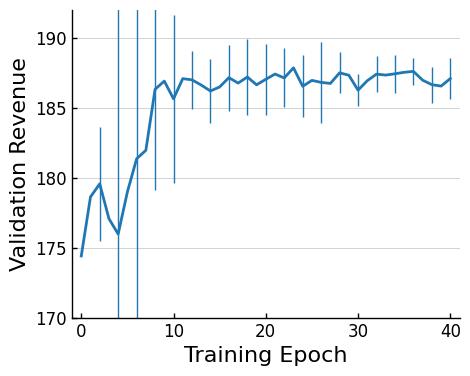

In [514]:
names = ['A2C2023-02-19-21-39-54','A2C2023-02-19-22-26-15','A2C2023-02-19-22-26-23','A2C2023-02-19-22-26-37','A2C2023-02-19-22-26-46']
list_ = []
for name in names:
    with open(r'log/' +name, 'r') as f:
        data = f.readlines()
        result_list = []
        for line in data:
            if 'initial mean reward' in line:
                seg = re.split(' |\n', line)[-2]
                result_list.append(float(seg))
            if 'validate reward:' in line:
                seg = re.split(' |\n', line)[-2]
                result_list.append(float(seg))
        list_.append(result_list)
list_ = np.array(list_) 
y = list_.mean(0)
err = list_.max(0)-list_.min(0)
steps = np.arange(len(result_list))
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

x_major_locator=MultipleLocator(4)
ax1.xaxis.set_major_locator(x_major_locator)

plt.errorbar(steps, y, linewidth=2,yerr=err,errorevery=2,elinewidth=1,  )
#ax1.plot(steps[::3],result_list[::3],marker='D',markersize=7,color='#496C88')#color_rgb_list[3]

ax1.set_xlabel("Training Epoch",size=16)
ax1.set_ylabel('Validation Revenue',size=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1);###设置底部坐标轴的粗细
ax1.spines['left'].set_linewidth(1);####设置左边坐标轴的粗细
ax1.tick_params(direction='in', width=1)
ax1.set_xlim(-1,41)
ax1.set_xticks(steps[::10],size=12)
ax1.set_ylim(170,192)
ax1.set_yticks(range(170,192,5),size=12)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)
plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.savefig(r'plot/'+'rank_list_groundtruth'+'steps_'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           
plt.show()

/tmp/ipykernel_673860/4058732500.py:35: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


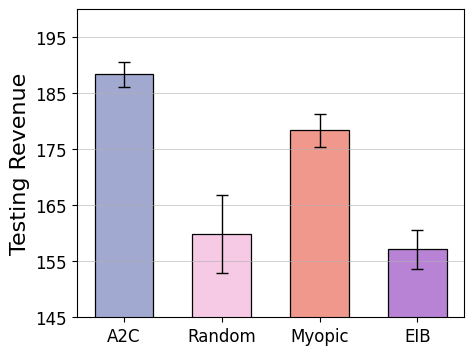

In [515]:
name = 'A2C2023-02-19-21-39-54'
with open(r'log/' + name, 'r') as f:
    data = f.readlines()
    OA_list = []
    Myopic_list = []
    EIB_list = []
    for line in data:
        if 'mean test reward:' in line:
            OA_list.append(float(line.split(',')[-3]))
            Myopic_list.append(float(line.split(',')[-2]))
            EIB_list.append(float(line.split(',')[-1]))

with open(r'log/' + name, 'r') as f:
    data = f.readlines()
    seller_list = []
    for line in data:
        if 'mean test reward:' in line:
            seller_list.append(float(line.split(',')[-4][-8:]))


y = [np.mean(seller_list), np.mean(OA_list),np.mean(Myopic_list), np.mean(EIB_list)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
std_err = [(np.max(seller_list)-np.min(seller_list)),(np.max(OA_list)-np.min(OA_list)),
           (np.max(Myopic_list)-np.min(Myopic_list)),(np.max(EIB_list)-np.min(EIB_list))]
error_params=dict(elinewidth=1,ecolor='black',capsize=4)#设置误差标记参数

ax.bar([1,2,3,4],y,width=0.6,color=['#A1A9D0','#F6CAE5','#F0988C','#B883D4'],edgecolor='black',linewidth=0.9,yerr=std_err,error_kw=error_params,\
                    tick_label=['A2C', 'Random', 'Myopic', 'EIB'])
ax.set_ylim(145,200)
ax.set_yticks(range(145,200,10),size=12)
plt.ylabel('Testing Revenue',size=16)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)
plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.savefig(r'plot/'+'rank_list_groundtruth'+'test'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           


In [509]:
y

[188.38551999999999, 159.90947000000003, 178.36845499999998, 157.14707]

In [511]:
for i in y:
    print((188.38551999999999-i)/i)

0.0
0.17807607016645077
0.05615939769170509
0.19878480712367064


/tmp/ipykernel_673860/3859239622.py:35: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


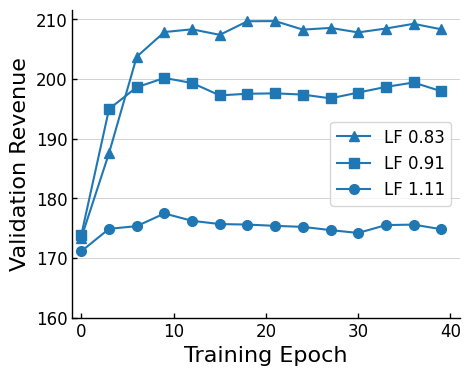

In [516]:
names=['A2C2023-02-19-21-40-11','A2C2023-02-19-21-40-00','A2C2023-02-19-21-39-57']
markers = ['^','s','o']
lines = ['--','-','-.']
labels = ['LF 0.83','LF 0.91','LF 1.11']
colors = ['#B883D4','#F0988C','#A1A9D0']
colors = ['#1f77b4','#1f77b4','#1f77b4']
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
for i in range(3):
    with open(r'log/' + names[i], 'r') as f:
        data = f.readlines()
        result_list = []
        for line in data:
            if 'initial mean reward' in line:
                seg = re.split(' |\n', line)[-2]
                result_list.append(float(seg))
            if 'validate reward:' in line:
                seg = re.split(' |\n', line)[-2]
                result_list.append(float(seg))
    steps = np.arange(len(result_list))
    x_major_locator=MultipleLocator(4)
    ax1.xaxis.set_major_locator(x_major_locator)
    ax1.plot(steps[::3],result_list[::3],marker=markers[i],markersize=7,label = labels[i],color=colors[i])#color_rgb_list[3]
ax1.set_xlabel("Training Epoch",size=16)
ax1.set_ylabel('Validation Revenue',size=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1);###设置底部坐标轴的粗细
ax1.spines['left'].set_linewidth(1);####设置左边坐标轴的粗细
ax1.tick_params(direction='in', width=1)
ax1.set_xlim(-1,41)
ax1.set_xticks(steps[::10],size=12)
ax1.set_yticks(range(160,220,10),size=12)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)
plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.legend(loc='center right',prop = {'size':12})
plt.savefig(r'plot/'+'load_factor_'+'steps_'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           
plt.show()

/tmp/ipykernel_673860/256578140.py:46: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


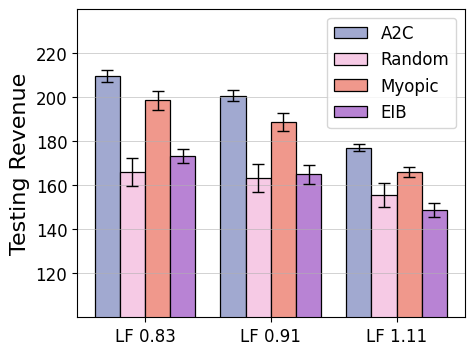

In [517]:
names=['A2C2023-02-19-21-40-11','A2C2023-02-19-21-40-00','A2C2023-02-19-21-39-57']
labels = ['LF 0.83','LF 0.91','LF 1.11']
datas = []
for i in range(4):
    datas.append([])
error = []
for i in range(4):
    error.append([])
for i in range(3):
    with open(r'log/' + names[i], 'r') as f:
        data = f.readlines()
        OA_list = []
        Myopic_list = []
        EIB_list = []
        seller_list = []
        for line in data:
            if 'mean test reward:' in line:
                OA_list.append(float(line.split(',')[-3]))
                Myopic_list.append(float(line.split(',')[-2]))
                EIB_list.append(float(line.split(',')[-1]))
                seller_list.append(float(line.split(',')[-4][-8:]))
        datas[0].append(np.mean(seller_list))
        datas[1].append(np.mean(OA_list))
        datas[2].append(np.mean(Myopic_list))
        datas[3].append(np.mean(EIB_list))
        error[0].append(np.max(seller_list)-np.min(seller_list))
        error[1].append(np.max(OA_list)-np.min(OA_list))
        error[2].append(np.max(Myopic_list)-np.min(Myopic_list))
        error[3].append(np.max(EIB_list)-np.min(EIB_list))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))    
colors=['#A1A9D0','#F6CAE5','#F0988C','#B883D4']
error_params=dict(elinewidth=1,ecolor='black',capsize=4)#设置误差标记参数
# 四组数据
x = np.arange(len(labels))  # x轴刻度标签位置
width = 0.2  # 柱子的宽度
# 计算每个柱子在x轴上的位置，保证x轴刻度标签居中
ax.bar(x - 1.5*width, datas[0], width, label='A2C',color = colors[0],edgecolor='black',linewidth=0.9,yerr=error[0],error_kw=error_params)
ax.bar(x - 0.5*width, datas[1], width, label='Random',color = colors[1],edgecolor='black',linewidth=0.9,yerr=error[1],error_kw=error_params)
ax.bar(x + 0.5*width, datas[2], width, label='Myopic',color = colors[2],edgecolor='black',linewidth=0.9,yerr=error[2],error_kw=error_params)
ax.bar(x + 1.5*width, datas[3], width, label='EIB',color = colors[3],edgecolor='black',linewidth=0.9,yerr=error[3],error_kw=error_params)
ax.set_ylim(100,240)
ax.set_yticks(range(120,230,20),size=12)
plt.ylabel('Testing Revenue',size=16)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)
plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
# x轴刻度标签位置不进行计算
plt.xticks(x, labels=labels)
plt.legend(prop = {'size':12})
plt.savefig(r'plot/'+'load_factor_'+'test'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           

plt.show()


/tmp/ipykernel_673860/3986888811.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


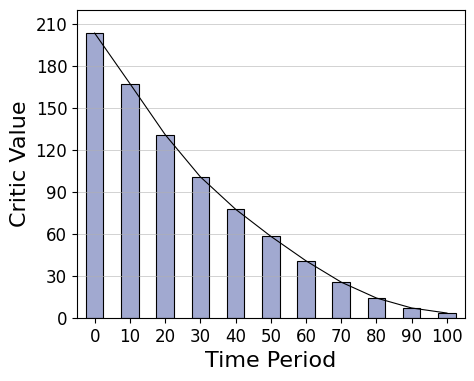

In [518]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

name = 'A2C2023-02-19-23-40-46'
FILE='change/'+name+'test_value_list'+str(0)+'.npy'

R_list0 = np.load(FILE,allow_pickle=True)
MAX_DAY = 0
for i in range(1,20):
    FILE='change/'+name+'test_value_list'+str(i)+'.npy'
    R_list = np.load(FILE,allow_pickle=True)
    for j in range(len(R_list0)):#对于每一天
        if len(R_list[j])>MAX_DAY:
            MAX_DAY = len(R_list[j])
        #ax.plot(np.arange(len(R_list[j])),R_list[j],color='#A1A9D0')
        R_list0[j] += R_list[j]
R_list0 = R_list0/20
R_ = np.zeros(MAX_DAY)
R_count = np.zeros(MAX_DAY)
for r_day in R_list0:
    R_[:len(r_day)] = R_[:len(r_day)]+r_day
    R_count[:len(r_day)] += 1
R_ = R_/R_count       

width = 5  # 柱子的宽度
ax.bar(np.arange(len(R_))[0::10], R_[0::10] , 
       color = '#A1A9D0', width = width,
       edgecolor='black',linewidth=0.8)#/R_OA[10::10] -1   
ax.plot(np.arange(len(R_))[0::10],R_[0::10],color = 'black',linewidth=0.8)

plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.xlabel("Time Period",size=16)
plt.ylabel('Critic Value',size=16)
ax.tick_params(labelsize=12)
ax.set_xlim(-5,105)
ax.set_xticks(np.arange(0,110,10),size=12)
ax.set_ylim(0,220)
ax.set_yticks(range(0,220,30),size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig(r'plot/'+'critic'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           

plt.show()

/tmp/ipykernel_673860/1509245029.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major',axis='y',linewidth=0.4 )


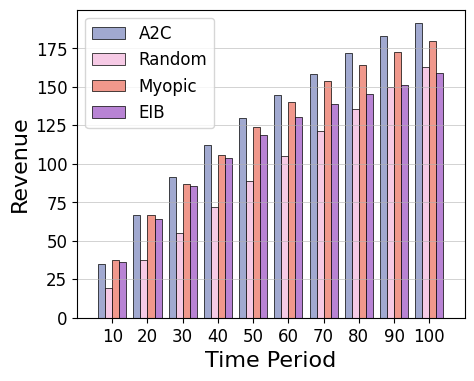

In [520]:
colors=['#A1A9D0','#F6CAE5','#F0988C','#B883D4']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

name = 'A2C2023-02-19-23-40-46'
name_ = ['R','ROA','RM','RE']
method = ['A2C','Random','Myopic','EIB']
multi = [-1.5,-0.5,0.5,1.5]

for c in [0,1,2,3]:
    FILE='change/'+name+'change_of_'+name_[c]+'_list'+str(0)+'.npy'
    R_list0 = np.load(FILE,allow_pickle=True)
    MAX_DAY = 0
    for i in range(1,20):
        FILE='change/'+name+'change_of_'+name_[c]+'_list'+str(i)+'.npy'
        R_list = np.load(FILE,allow_pickle=True)
        for j in range(len(R_list0)):#对于每一天
            if len(R_list[j])>MAX_DAY:
                MAX_DAY = len(R_list[j])
            #ax.plot(np.arange(len(R_list[j])),R_list[j],color='#A1A9D0')
            R_list0[j] += R_list[j]
    R_list0 = R_list0/20
    R_ = np.zeros(MAX_DAY)
    R_count = np.zeros(MAX_DAY)
    for r_day in R_list0:
        R_[:len(r_day)] = R_[:len(r_day)]+r_day
        R_count[:len(r_day)] += 1
    R_ = R_/R_count       

    width = 2  # 柱子的宽度
    ax.bar(np.arange(len(R_))[10::10] + multi[c]*width, R_[10::10] , 
           color = colors[c], width = width,label=method[c],
           edgecolor='black',linewidth=0.5)#/R_OA[10::10] -1                 bottom=[1]*len(R_[10::10]) ,
    
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.xaxis.set_ticks_position('bottom')#  要挪动底部的X轴，所以先目光锁定底部！
# 在这里，position位置参数有三种，这里用到了“按Y轴刻度位置挪动”
# 'data'表示按数值挪动，其后数字代表挪动到Y轴的刻度值
#ax.spines['bottom'].set_position(('data', 1))
ax.set_ylim(0,200)
ax.set_yticks(np.arange(0,200,25),size=12)
ax.set_xlim(0,110)
ax.set_xticks(np.arange(10,110,10),size=12)
plt.ylabel('Revenue',size=16)
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)
plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
plt.xlabel("Time Period",size=16)
plt.legend(prop = {'size':12})
#plt.title('Revenue Ratio Against Random',size=20)
plt.savefig(r'plot/'+'Revenue'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           

plt.show()

/tmp/ipykernel_673860/457289959.py:50: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[axs[0],axs[1]].grid(b=True, which='major',linewidth=0.4 )


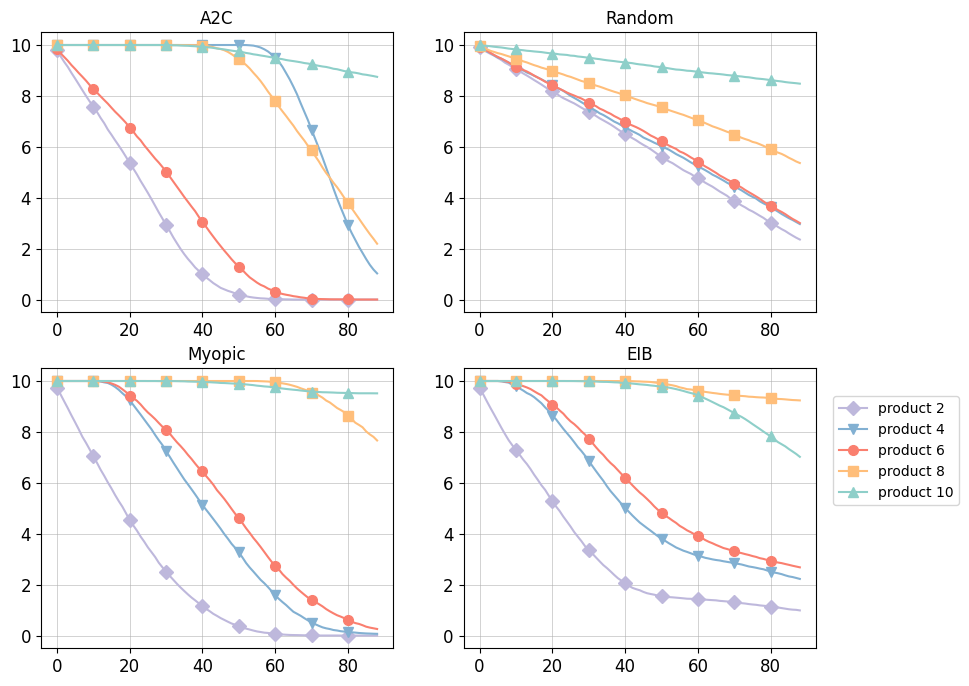

In [524]:
#colors=['#A1A9D0','#F6CAE5','#F0988C','#B883D4']
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))#ax[1, 1]
color_ = []
for i in range(10):
    color_.append(((30+8*i)/255,(50+8*i)/255,(90+12*i)/255))
color_ = ['#BEB8DC','#82B0D2','#FA7F6F','#FFBE7A','#8ECFC9']
#color_=['#A1A9D0','#F6CAE5','#F0988C','#B883D4','#96CCCB']
m = ['D','v','o','s','^']
#color_ = ['#934B43','#F27970','#BB9727','#54B345','#32B897','#05B9E2',(64/255,150/255,201/255),'#8983BF','#C76DA2',(243/255,69/255,133/255)]
name = 'A2C2023-02-19-23-40-46'
name_ = ['inv','invOA','invM','invE']
method = ['A2C','Random','Myopic','EIB']

for c,axs in zip([0,1,2,3],[(0,0),(0,1),(1,0),(1,1)]):
    
    FILE='change/'+name+'change_of_'+name_[c]+'_list'+str(0)+'.npy'
    R_list0 = np.load(FILE,allow_pickle=True)
    MAX_DAY = 200
    for i in range(1,20):#对于每一轮
        FILE='change/'+name+'change_of_'+name_[c]+'_list'+str(i)+'.npy'
        R_list = np.load(FILE,allow_pickle=True)
        for j in range(len(R_list0)):#对于每一天
            if len(R_list[j])<MAX_DAY:
                MAX_DAY = len(R_list[j])
            #ax.plot(np.arange(len(R_list[j])),R_list[j],color='#A1A9D0')
            R_list0[j] += R_list[j]
    R_list0 = R_list0/20
    R_ = np.zeros((MAX_DAY,10))
    R_count = np.zeros(MAX_DAY)
    for r_day in R_list0:
        #print(R_[:len(r_day)],r_day)
        R_ += r_day[:MAX_DAY]
        #R_count[:len(r_day)] += 1
    R_ = R_/len(R_list0)
    
    products_price = [1.838419913,1.992458678,1.874724518,1.515151515,3.28728191,2.695362718,1.032467532,4.485454545,1.57983683,1.02]
    sorted_id = sorted(range(len(products_price)), key=lambda k: products_price[k], reverse=True)
    col = 0
    for p in sorted_id[1::2]:
        ax[axs[0],axs[1]].plot(np.arange(len(R_[:,p])),R_[:,p],label='product '+str(2+2*col),color=color_[col],
                               marker=m[col],markevery=10,markersize=7,linewidth=1.5)
        col+=1
    ax[axs[0],axs[1]].tick_params(axis='x',labelsize=12)
    ax[axs[0],axs[1]].tick_params(axis='y',labelsize=12)
    #ax[axs[0],axs[1]].set_xlabel("Time Period",size=20)
    #ax[axs[0],axs[1]].set_ylabel('Inventory Level',size=20)
    ax[axs[0],axs[1]].legend(prop = {'size':12})
    ax[axs[0],axs[1]].set_ylim(-0.5,10.5)
    ax[axs[0],axs[1]].set_title(method[c],size=12)
    ax[axs[0],axs[1]].grid(b=True, which='major',linewidth=0.4 )
ax[0,0].legend_.remove()
ax[0,1].legend_.remove()
ax[1,0].legend_.remove()
ax[1,1].legend(loc=2, bbox_to_anchor=(1.05,0.9),borderaxespad = 0.) 
    
    
#ax.set_ylim(0.95,1.98)
#ax.set_yticks(np.arange(0.95,1.98,0.15),size=12)
#ax.set_xlim(0,110)
#ax.set_xticks(np.arange(10,110,10),size=12)

#plt.grid(b=True, which='major',axis='y',linewidth=0.4 )
#plt.title('Revenue Ratio Against Random',size=20)
plt.savefig(r'plot/'+'inventory'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')           

plt.show()